# AOL-based Hyperbolic Fit and Evaluation (load directly from rst)
This notebook loads one or more rst roots (each contains per-workload folders with LOCAL/NUMA perf dumps),
computes S, P, AOL, fits K = 1/(a + b/AOL), and evaluates S_pred = P * K(AOL).

In [1]:
from pathlib import Path
import sys, json, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Project root and script location
# Define repository root path
REPO_ROOT = Path('/home/yancho/CLionProjects/Melody').resolve()
SCRIPTS = REPO_ROOT / 'spa' / 'proc'
OUT_DIR = SCRIPTS / 'out'

# Enable imports like 'import spa...'
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# Performance counter column names (will be suffixed with _local/_numa)
A1 = 'OFFCORE_REQUESTS_OUTSTANDING.CYCLES_WITH_DEMAND_DATA_RD'
A3 = 'OFFCORE_REQUESTS.DEMAND_DATA_RD'
CALT = 'CPU_CLK_UNHALTED.THREAD'
CCYC = 'cycles'
SLLC = 'CYCLE_ACTIVITY.STALLS_L3_MISS'

# Reuse parsing from update_data
import spa.proc.update_data as u

def load_joined_from_rst(rst_dir: Path) -> pd.DataFrame:
    rst_dir = Path(rst_dir).resolve()
    # Read LOCAL and NUMA data from rst directory
    loc_list = u.read_data(str(rst_dir), 'LOCAL')
    num_list = u.read_data(str(rst_dir), 'NUMA')
    df_loc = pd.DataFrame(loc_list).set_index('workload_name')
    df_num = pd.DataFrame(num_list).set_index('workload_name')
    # Inner join LOCAL and NUMA dataframes
    joined = df_loc.add_suffix('_local').join(df_num.add_suffix('_numa'), how='inner').sort_index()
    return joined

def compute_vectors(joined: pd.DataFrame, eps: float = 1e-12):
    # cycle base (prioritize CPU clocks)
    if f'{CALT}_local' in joined and f'{CALT}_numa' in joined:
        c_loc = joined[f'{CALT}_local']
        c_num = joined[f'{CALT}_numa']
    else:
        c_loc = joined[f'{CCYC}_local']
        c_num = joined[f'{CCYC}_numa']
    # Slowdown S = (C_numa - C_local) / C_local
    S = (c_num - c_loc) / (c_loc + eps)

    # Base prediction P = sLLC / C_local
    if f'{SLLC}_local' not in joined:
        raise ValueError('Missing sLLC column in rst dataset')
    P = joined[f'{SLLC}_local'] / (c_loc + eps)

    # Average Offcore Latency (AOL) = A1/A3 (LOCAL)
    a1_col = f'{A1}_local'
    a3_col = f'{A3}_local'
    if a1_col not in joined or a3_col not in joined:
        raise ValueError('Missing A1/A3 in rst dataset; required for AOL')
    AOL = joined[a1_col] / (joined[a3_col] + eps)

    # K = S / P (Slowdown gain factor)
    K = S / np.where(np.abs(P) < eps, np.nan, P)
    return AOL, P, S, K

def fit_hyperbolic(AOL: np.ndarray, K: np.ndarray):
    # Fit the hyperbolic model: 1/K = a + b/AOL
    eps = 1e-12
    x = 1.0 / np.clip(AOL, eps, None)
    y = 1.0 / np.clip(K, eps, None)
    X = np.vstack([np.ones_like(x), x]).T
    mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
    Xf, yf = X[mask], y[mask]
    # Perform least squares fitting
    a, b = np.linalg.lstsq(Xf, yf, rcond=None)[0]
    return float(a), float(b), mask

def predict_S(P: np.ndarray, AOL: np.ndarray, a: float, b: float):
    # Predict K_hat using the fitted hyperbolic function
    K_hat = 1.0 / (a + b / np.clip(AOL, 1e-12, None))
    # Predict Slowdown S_hat = P * K_hat
    return P * K_hat, K_hat

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-9, None)))
    # Pearson correlation coefficient
    pear = np.corrcoef(y_true, y_pred)[0,1] if y_true.size >= 2 else np.nan
    return dict(mae=float(mae), rmse=float(rmse), mape=float(mape), pearson=float(pear))

--- Starting Training for SOAR Base Model 'k' ---
Loading training data from: rst_gapbs_13counter_190ns
Loading training data from: rst_cpu2017_13counter_190ns

--- Training Complete ---
Fitted SOAR Base Model k = 1.552168
-------------------------

--- Starting Testing ---
--- Testing on: rst_gapbs_13counter_190ns ---
Using k = 1.552168
Evaluation Metrics: {
  "mae": 0.1835853699976747,
  "rmse": 0.22116635234397228,
  "mape": 0.41079488787862695,
  "pearson": 0.8748433769495154
}
R² Score: 0.432102



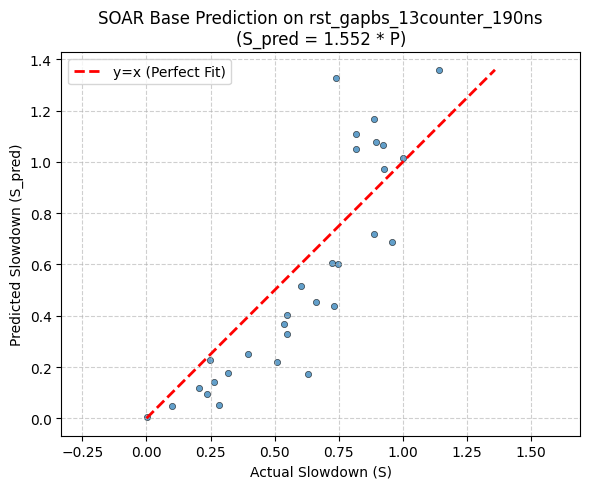

--- Testing on: rst_cpu2017_13counter_190ns ---
Using k = 1.552168
Evaluation Metrics: {
  "mae": 0.16739432744556249,
  "rmse": 0.3584242807115905,
  "mape": 0.8588877659967923,
  "pearson": 0.5613225306064578
}
R² Score: 0.089680



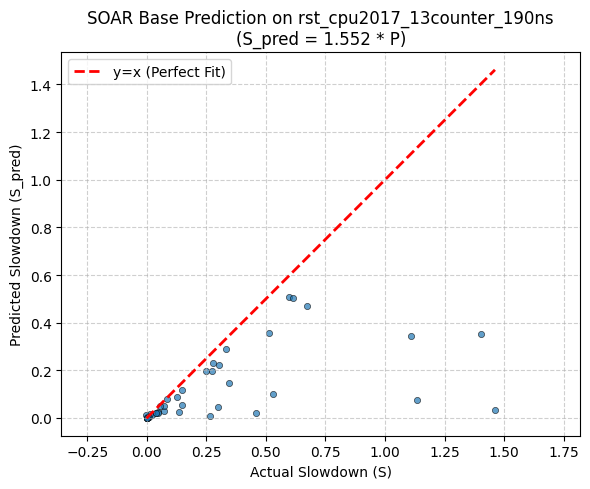

--- Testing on: rst_pbbs_13counter_190ns ---
Using k = 1.552168
Evaluation Metrics: {
  "mae": 0.09345416464307969,
  "rmse": 0.11597829278011658,
  "mape": 0.4116510765800436,
  "pearson": 0.9483917059085828
}
R² Score: 0.766002



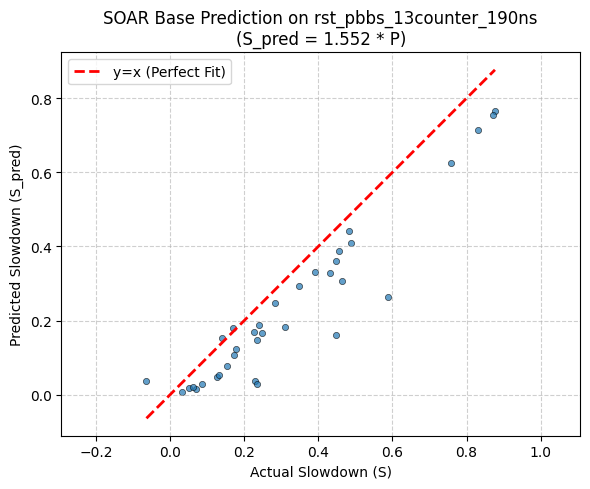

In [2]:
# --- 2. (SOAR Base Model) ---
def fit_soar_base_k(P: np.ndarray, S: np.ndarray, eps: float = 1e-12) -> float:
    """
    soar_base k (S = k * P).
    k = Σ(P * S) / Σ(P^2)
    """
    P = np.asarray(P)
    S = np.asarray(S)

    mask = np.isfinite(P) & np.isfinite(S)
    P_fit, S_fit = P[mask], S[mask]

    numerator = np.sum(P_fit * S_fit)
    denominator = np.sum(P_fit**2)

    if denominator < eps:
        print("Warning: Denominator is close to zero, k might be unstable.")
        return 1.0

    k = numerator / denominator
    return float(k)

def predict_S_soar_base(P: np.ndarray, k: float) -> np.ndarray:
    """ k (S_pred = k * P)."""
    return np.asarray(P) * k

# --- 3. ---
def test_soar_base(rst_dir: Path, k: float):
    """
     soar_base .

    Args:
        rst_dir: LOCAL/ NUMA/ .
        k: k .
    """
    print(f"--- Testing on: {rst_dir.name} ---")

    # 1. P S
    joined = load_joined_from_rst(rst_dir)
    if joined.empty:
        return

    _, P, S, _ = compute_vectors(joined)

    # 2. k
    S_pred = predict_S_soar_base(P.to_numpy(), k)

    # 3.
    eval_mask = np.isfinite(S_pred) & np.isfinite(S)
    s_actual = S[eval_mask].to_numpy()
    s_predicted = S_pred[eval_mask]

    if s_actual.size < 2:
        print("Not enough valid data to evaluate.")
        return

    eva = metrics(s_actual, s_predicted)
    r2 = r2_score(s_actual, s_predicted)

    print(f"Using k = {k:.6f}")
    print('Evaluation Metrics:', json.dumps(eva, indent=2))
    print(f'R² Score: {r2:.6f}\n')

    # 4. ()
    plt.figure(figsize=(6, 5))
    plt.scatter(s_actual, s_predicted, s=20, alpha=0.7, edgecolors='k', linewidths=0.5)

    lims = [min(s_actual.min(), s_predicted.min()), max(s_actual.max(), s_predicted.max())]
    lim_min = min(0, lims[0])
    lim_max = max(0, lims[1])
    plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', lw=2, label='y=x (Perfect Fit)')

    plt.xlabel('Actual Slowdown (S)')
    plt.ylabel('Predicted Slowdown (S_pred)')
    plt.title(f'SOAR Base Prediction on {rst_dir.name}\n(S_pred = {k:.3f} * P)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


# --- 4. ---
RST_DIRS_TRAIN = [
    REPO_ROOT / 'spa' / 'proc' / 'rst' / 'rst_gapbs_13counter_190ns',
    REPO_ROOT / 'spa' / 'proc' / 'rst' / 'rst_cpu2017_13counter_190ns',
]

#
print("--- Starting Training for SOAR Base Model 'k' ---")
all_P = []
all_S = []
for rst in RST_DIRS_TRAIN:
    print(f"Loading training data from: {rst.name}")
    joined = load_joined_from_rst(rst)
    if joined.empty:
        continue
    _, P, S, _ = compute_vectors(joined)
    all_P.append(P)
    all_S.append(S)

if not all_P:
    print("No training data found. Exiting.")
else:
    #  P S
    P_train = pd.concat(all_P).to_numpy()
    S_train = pd.concat(all_S).to_numpy()

    #  k
    k_fitted = fit_soar_base_k(P_train, S_train)
    print(f"\n--- Training Complete ---")
    print(f"Fitted SOAR Base Model k = {k_fitted:.6f}")
    print("-------------------------\n")


RST_DIRS_TEST = [
    REPO_ROOT / 'spa' / 'proc' / 'rst' / 'rst_gapbs_13counter_190ns',
    REPO_ROOT / 'spa' / 'proc' / 'rst' / 'rst_cpu2017_13counter_190ns',
    REPO_ROOT / 'spa' / 'proc' / 'rst' / 'rst_pbbs_13counter_190ns'
]
print("--- Starting Testing ---")
for rst_dir_test in RST_DIRS_TEST:
    test_soar_base(rst_dir_test, k_fitted)

In [12]:
!pwd

/home/yancho/CLionProjects/Melody/spa/proc/notebooks


Fitted parameters: a=0.317760, b=7.329282
Evaluation (all valid rows): {
  "mae": 0.16946025361418102,
  "rmse": 0.2998345614006833,
  "mape": 0.7287234971766461,
  "pearson": 0.7497918495846941
}
R²: 0.381096
Saved predictions to /home/yancho/CLionProjects/Melody/spa/proc/out/hyper_predictions.csv


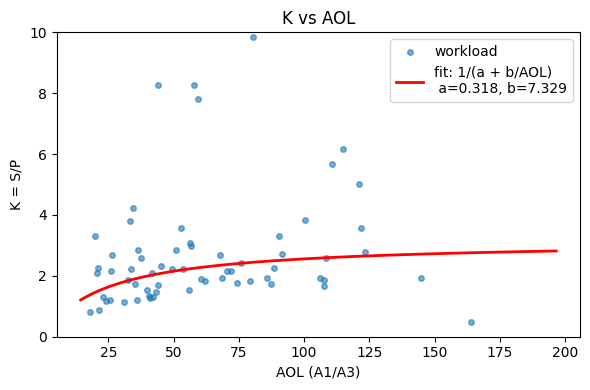

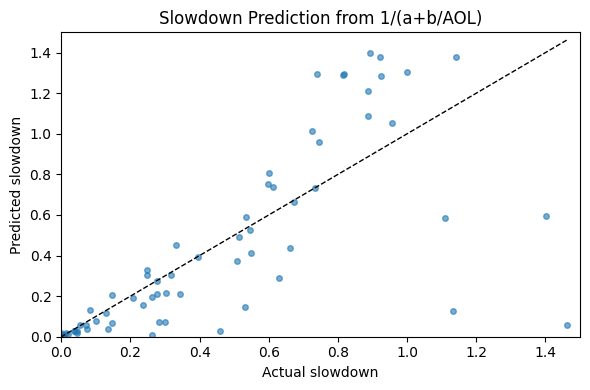

In [3]:
# Data sources (absolute paths)
RST_DIRS = [
    REPO_ROOT / 'spa' / 'proc' / 'rst' / 'rst_gapbs_13counter_190ns',
    REPO_ROOT / 'spa' / 'proc' / 'rst' / 'rst_cpu2017_13counter_190ns',
]

# Build combined data
records = []
for rst in RST_DIRS:
    joined = load_joined_from_rst(rst)
    AOL, P, S, K = compute_vectors(joined)
    df = pd.DataFrame({
        'dataset': rst.name,
        'workload': AOL.index,
        'AOL': AOL.values,
        'P': P.values,
        'S': S.values,
        'K': K.values,
    })
    records.append(df)
data = pd.concat(records, ignore_index=True)

# Fit using only valid points (AOL>0, K>0 and finite)
valid = (data['AOL'] > 0) & np.isfinite(data['AOL']) & np.isfinite(data['K']) & (data['K'] > 0)
fit_data = data[valid].copy()
a, b, _ = fit_hyperbolic(fit_data['AOL'].to_numpy(), fit_data['K'].to_numpy())
print(f'Fitted parameters: a={a:.6f}, b={b:.6f}')

# Predict and evaluate
S_pred, K_hat = predict_S(data['P'].to_numpy(), data['AOL'].to_numpy(), a, b)
data['K_hat'] = K_hat
data['S_pred'] = S_pred
eval_mask = np.isfinite(S_pred) & np.isfinite(data['S'])
eva = metrics(data['S'][eval_mask].to_numpy(), data['S_pred'][eval_mask].to_numpy())
r2 = r2_score(data['S'][eval_mask].to_numpy(), data['S_pred'][eval_mask].to_numpy())
print('Evaluation (all valid rows):', json.dumps(eva, indent=2))
print(f'R²: {r2:.6f}')

# Save predictions.csv (workload_name = dataset:workload)
pred_df = pd.DataFrame({
    'workload_name': (data.loc[eval_mask, 'dataset'].astype(str) + ':' + data.loc[eval_mask, 'workload'].astype(str)),
    'actual_slowdown': data.loc[eval_mask, 'S'].to_numpy(),
    'predicted_slowdown': data.loc[eval_mask, 'S_pred'].to_numpy()
})
pred_df['abs_error'] = np.abs(pred_df['actual_slowdown'] - pred_df['predicted_slowdown'])
pred_df['pct_error'] = pred_df['abs_error'] / np.clip(np.abs(pred_df['actual_slowdown']), 1e-9, None)

OUT_HYPER = OUT_DIR / 'hyper_predictions.csv'
OUT_HYPER.parent.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(OUT_HYPER, index=False)
print('Saved predictions to', OUT_HYPER)
pred_df.head(10)

# Optional: Plotting (can be commented out if not needed)
plt.figure(figsize=(6,4))
plt.scatter(fit_data['AOL'], fit_data['K'], s=16, alpha=0.6, label='workload')
xs = np.linspace(fit_data['AOL'].min()*0.8, fit_data['AOL'].max()*1.2, 200)
ys = 1.0 / (a + b / np.clip(xs, 1e-12, None))
plt.plot(xs, ys, 'r-', lw=2, label=f'fit: 1/(a + b/AOL)\n a={a:.3f}, b={b:.3f}')
plt.ylim(0, 10)
plt.xlabel('AOL (A1/A3)')
plt.ylabel('K = S/P')
plt.title('K vs AOL')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/plot_k_vs_aol.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(data['S'][eval_mask], data['S_pred'][eval_mask], s=16, alpha=0.6)
lims = [min(data['S'][eval_mask].min(), data['S_pred'][eval_mask].min()),
max(data['S'][eval_mask].max(), data['S_pred'][eval_mask].max())]
plt.plot(lims, lims, 'k--', lw=1)
plt.ylim(0, 1.5); plt.xlim(0, 1.5)
plt.xlabel('Actual slowdown')
plt.ylabel('Predicted slowdown')
plt.title('Slowdown Prediction from 1/(a+b/AOL)')
plt.tight_layout()
plt.savefig('../plots/plot_prediction.pdf', bbox_inches='tight')
plt.show()

In [4]:
# 2) PBBS rst directories to be evaluated
RST_DIRS = [
    REPO_ROOT / 'spa' / 'proc' / 'rst' / 'rst_pbbs_13counter_190ns',
]

# 3) Build data (AOL, P, S, K) on PBBS
records = []
for rst in RST_DIRS:
    joined = load_joined_from_rst(rst)
    AOL, P, S, K = compute_vectors(joined)
    df = pd.DataFrame({
        'dataset': rst.name,
        'workload': AOL.index,
        'AOL': AOL.values,
        'P': P.values,
        'S': S.values,
        'K': K.values,
    })
    records.append(df)

data = pd.concat(records, ignore_index=True)

# 4) Evaluate only on valid samples: AOL>0, P is finite, S is finite
eps = 1e-12
eval_mask = (
    (data['AOL'] > 0) &
    np.isfinite(data['AOL']) &
    np.isfinite(data['P']) &
    np.isfinite(data['S'])
)

eval_data = data[eval_mask].copy()
print(f"Total PBBS samples: {len(data)}, valid for eval: {len(eval_data)}")

# 5) Compute predicted slowdown S_pred using fixed a and b
S_pred, K_hat = predict_S(eval_data['P'].to_numpy(),
                          eval_data['AOL'].to_numpy(),
                          a, b)
eval_data['K_hat'] = K_hat
eval_data['S_pred'] = S_pred

# 6) Compute error metrics
eva = metrics(eval_data['S'].to_numpy(), eval_data['S_pred'].to_numpy())
r2 = r2_score(eval_data['S'].to_numpy(), eval_data['S_pred'].to_numpy())
print('PBBS hyperbolic eval (using fixed a,b):', json.dumps(eva, indent=2))
print(f'R² on PBBS: {r2:.6f}')

Total PBBS samples: 35, valid for eval: 35
PBBS hyperbolic eval (using fixed a,b): {
  "mae": 0.09725147428830185,
  "rmse": 0.12980462346480967,
  "mape": 0.3725711276446872,
  "pearson": 0.9506580538089062
}
R² on PBBS: 0.706884


In [5]:
import subprocess, json

# Train model (uses built-in RST_LIST, saves to spa/proc/out/multi)
# The --add-aol flag includes Average Offcore Latency as a feature
subprocess.run([sys.executable, str(SCRIPTS / 'train_from_multi_rst.py'), '--add-aol'],
check=True, cwd=str(REPO_ROOT))

# Perform feature ablation on the combined dataset (saves to spa/proc/out/multi)
combined_dir = SCRIPTS / 'out' / 'multi' / 'combined'
subprocess.run([sys.executable, str(SCRIPTS / 'feature_ablation_pro.py'),
'--dataset', str(combined_dir),
'--feature-mode', 'all',
'--cv', 'loo',
'--n-jobs', '4', # warning: never use -1, it will overload cpu+memory!
'--out-json', str(SCRIPTS / 'out' / 'multi' / 'ablation_pro.json'),
'--out-csv', str(SCRIPTS / 'out' / 'multi' / 'ablation_pro.csv')],
check=True, cwd=str(REPO_ROOT))

# Print summary metrics
base = json.loads((SCRIPTS / 'out' / 'multi' / 'metrics.json').read_text())
abl = json.loads((SCRIPTS / 'out' / 'multi' / 'ablation_pro.json').read_text())
print('Baseline metrics:', json.dumps(base.get('metrics', {}), indent=2))
print('Best single (top-3):', json.dumps(abl.get('best_single', [])[:3], indent=2))
print('Forward path:', json.dumps(abl.get('forward_path', []), indent=2))

Available features (37):
Index(['ipc', 'time_local', 'log_cycles', 'log_time',
       'CYCLE_ACTIVITY.STALLS_MEM_ANY_per_cycle',
       'CYCLE_ACTIVITY.STALLS_MEM_ANY_per_instr',
       'EXE_ACTIVITY.BOUND_ON_STORES_per_cycle',
       'EXE_ACTIVITY.BOUND_ON_STORES_per_instr',
       'CYCLE_ACTIVITY.STALLS_L1D_MISS_per_cycle',
       'CYCLE_ACTIVITY.STALLS_L1D_MISS_per_instr',
       'CYCLE_ACTIVITY.STALLS_L2_MISS_per_cycle',
       'CYCLE_ACTIVITY.STALLS_L2_MISS_per_instr',
       'CYCLE_ACTIVITY.STALLS_L3_MISS_per_cycle',
       'CYCLE_ACTIVITY.STALLS_L3_MISS_per_instr',
       'EXE_ACTIVITY.1_PORTS_UTIL_per_cycle',
       'EXE_ACTIVITY.1_PORTS_UTIL_per_instr',
       'EXE_ACTIVITY.2_PORTS_UTIL_per_cycle',
       'EXE_ACTIVITY.2_PORTS_UTIL_per_instr',
       'PARTIAL_RAT_STALLS.SCOREBOARD_per_cycle',
       'PARTIAL_RAT_STALLS.SCOREBOARD_per_instr',
       'MEM_LOAD_RETIRED.L3_MISS_per_cycle',
       'MEM_LOAD_RETIRED.L3_MISS_per_instr',
       'CPU_CLK_UNHALTED.THREAD_per_cycle',
   

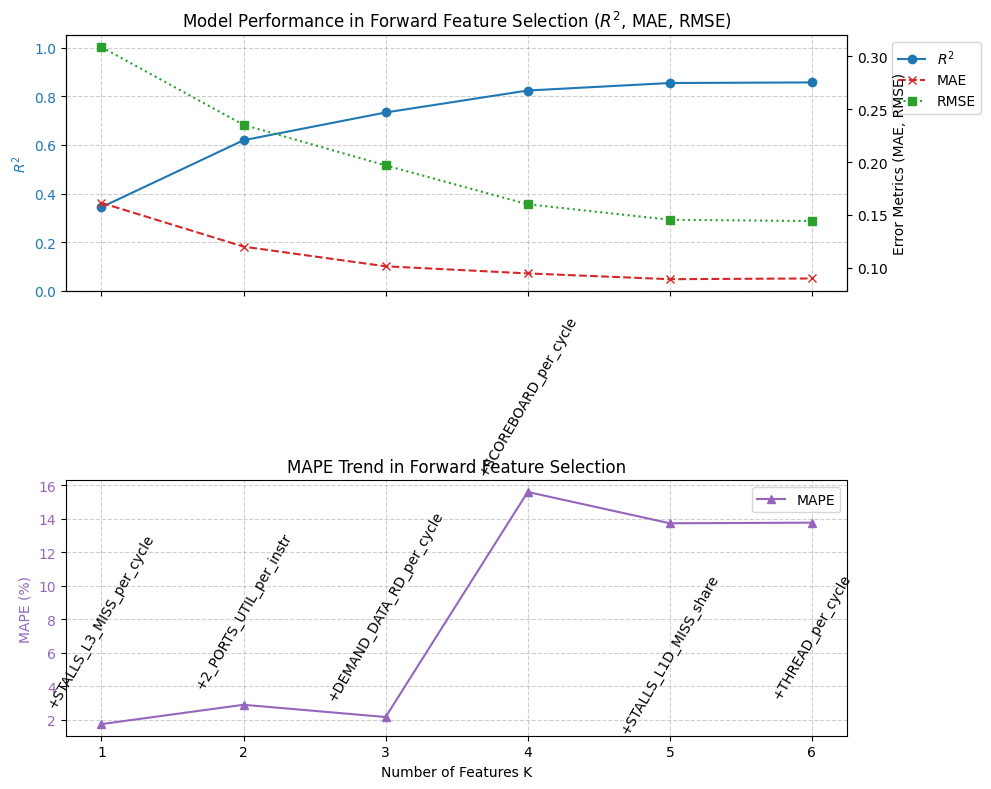

In [6]:
# ----------------------------------------------------
# Plot Forward Feature Selection Results
# ----------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

# --- Data Loading and Preparation (Mandatory Step) ---
# Assuming SCRIPTS is defined from Cell 1: SCRIPTS = REPO_ROOT / 'spa' / 'proc'
SCRIPTS = Path('/home/yancho/CLionProjects/Melody/spa/proc') 
abl_path = SCRIPTS / 'out' / 'multi' / 'ablation_pro.json'

# Load the forward path data from the JSON file generated by Cell 3
try:
    with open(abl_path, 'r') as f:
        ablation_results = json.load(f)
    fwd_data = ablation_results.get('forward_path', [])
    if not fwd_data:
        raise ValueError("Forward path data is empty in the JSON file.")
except FileNotFoundError:
    print(f"Error: Ablation results file not found at {abl_path}. Run Cell 3 first.")
    # Stop execution or return if data is missing
    # raise
    sys.exit(1)


# Convert list of dicts to DataFrame and prepare plotting labels
df = pd.DataFrame(fwd_data).set_index('k')
# Create a label for the feature added in that step (e.g., '+k: FEATURE_NAME')
df['added_feature_label'] = df.index.astype(str) + ': ' + df['added'].str.split('.').str[-1]
k_values = df.index

# --- Plotting ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# ----------------------------------------------------
# Subplot 1: R², MAE, RMSE Trends
# ----------------------------------------------------

ax1 = axes[0]
ax1.set_title('Model Performance in Forward Feature Selection ($R^2$, MAE, RMSE)')

color_r2 = 'tab:blue'
ax1.plot(k_values, df['r2'], marker='o', linestyle='-', color=color_r2, label='$R^2$')
ax1.tick_params(axis='y', labelcolor=color_r2)
ax1.set_ylabel('$R^2$', color=color_r2)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_ylim(0, 1.05)

ax2 = ax1.twinx()
color_mae = 'tab:red'
color_rmse = 'tab:green'

ax2.plot(k_values, df['mae'], marker='x', linestyle='--', color=color_mae, label='MAE')
ax2.plot(k_values, df['rmse'], marker='s', linestyle=':', color=color_rmse, label='RMSE')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylabel('Error Metrics (MAE, RMSE)', color='black')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right', bbox_to_anchor=(1.18, 1.0))


# ----------------------------------------------------
# Subplot 2: MAPE Trend (Separate for scale)
# ----------------------------------------------------

ax3 = axes[1]
ax3.set_title('MAPE Trend in Forward Feature Selection')
color_mape = 'tab:purple'
ax3.plot(k_values, df['mape'], marker='^', linestyle='-', color=color_mape, label='MAPE')
ax3.set_ylabel('MAPE (%)', color=color_mape)
ax3.tick_params(axis='y', labelcolor=color_mape)
ax3.grid(True, linestyle='--', alpha=0.6)
ax3.legend(loc='upper right')

# Set common X-axis labels and ticks
ax3.set_xlabel('Number of Features K')
ax3.set_xticks(df.index)
# Use the index values (K=1, 2, 3...) for tick labels
ax3.set_xticklabels(df.index) 


# Add annotation for added feature on the MAPE plot
for i, txt in enumerate(df['added_feature_label']):
    # The text to annotate: prepend with '+' and use the feature name
    feature_name = "+" + txt.split(': ')[1] 
    
    # --- Conditional Placement Logic (Simplified/Adjusted for better fit) ---
    # NOTE: The original conditional logic was complex; a simpler offset might work better
    
    # Place label slightly above the X-axis for all points
    text_offset = (0, 10) 
    rotation_angle = 60 
    vertical_alignment = 'bottom'
    xy_coords = (df.index.values[i], df['mape'].iloc[i]) 
    
    # Adjust for points where the label might clash or overlap,
    # specifically pushing points 4 and 5 (i=3, 4) down might be needed if they are high.
    if i >= len(df) - 2: # Last two points (K=4, 5)
        text_offset = (0, -35)
        vertical_alignment = 'top'

    ax3.annotate(feature_name, 
                 xy=xy_coords,
                 xytext=text_offset,
                 xycoords='data', 
                 textcoords='offset points', 
                 ha='center',
                 fontsize=10, 
                 rotation=rotation_angle, 
                 va=vertical_alignment)

plt.tight_layout()
plt.show()

In [7]:
# Retrain using features from forward_path (Reuses train_from_multi_rst.py)
import json, subprocess

# Read ablation forward_path and select the step with the best R²
abl_path = SCRIPTS / 'out' / 'multi' / 'ablation_pro.json'
fwd = json.loads(abl_path.read_text()).get('forward_path', [])
if not fwd:
    raise RuntimeError('forward_path is empty; run ablation first.')
print(fwd)
# Find the feature set with the maximum R²
best_step = max(fwd, key=lambda s: s.get('r2', float('-inf')))
full_features = best_step['features']
top_k = 3
selected_features = full_features[:top_k]

print('Selected features:', selected_features)

# Assemble command (include --add-aol if AOL is selected)
cmd = [sys.executable, str(SCRIPTS / 'train_from_multi_rst.py'),
'--out-dir', str(SCRIPTS / 'out' / 'multi'),
'--features', ",".join(selected_features)]
if 'AOL' in selected_features:
    cmd.append('--add-aol')

print('Running:', ' '.join(cmd))
subprocess.run(cmd, check=True, cwd=str(REPO_ROOT))

# Print new model metrics
metrics_path = SCRIPTS / 'out' / 'multi' / 'metrics.json'
print('Retrain metrics:', (metrics_path).read_text())

[{'k': 1, 'added': 'CYCLE_ACTIVITY.STALLS_L3_MISS_per_cycle', 'features': ['CYCLE_ACTIVITY.STALLS_L3_MISS_per_cycle'], 'mae': 0.1614676959532898, 'rmse': 0.3087889486641441, 'mape': 1.7301027918539227, 'r2': 0.3435772626484557}, {'k': 2, 'added': 'EXE_ACTIVITY.2_PORTS_UTIL_per_instr', 'features': ['CYCLE_ACTIVITY.STALLS_L3_MISS_per_cycle', 'EXE_ACTIVITY.2_PORTS_UTIL_per_instr'], 'mae': 0.12005834105766905, 'rmse': 0.2352241385223712, 'mape': 2.88604423428211, 'r2': 0.6190886693300357}, {'k': 3, 'added': 'OFFCORE_REQUESTS.DEMAND_DATA_RD_per_cycle', 'features': ['CYCLE_ACTIVITY.STALLS_L3_MISS_per_cycle', 'EXE_ACTIVITY.2_PORTS_UTIL_per_instr', 'OFFCORE_REQUESTS.DEMAND_DATA_RD_per_cycle'], 'mae': 0.10145496537228801, 'rmse': 0.19686538658112362, 'mape': 2.1534207062803667, 'r2': 0.7331920007663024}, {'k': 4, 'added': 'PARTIAL_RAT_STALLS.SCOREBOARD_per_cycle', 'features': ['CYCLE_ACTIVITY.STALLS_L3_MISS_per_cycle', 'EXE_ACTIVITY.2_PORTS_UTIL_per_instr', 'OFFCORE_REQUESTS.DEMAND_DATA_RD_per_

In [29]:
# Evaluate arbitrary rst + trained model (Reuse load_dataset, align features; minimal filtering)
from spa.proc.model_utils import load_dataset
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

def eval_model_on_rst(rst_dir: str, model_path: str, out_csv: str | None = None):
    rst_dir = Path(rst_dir).resolve()
    model_path = Path(model_path).resolve()

    eval_root = SCRIPTS / 'out' / 'eval' / rst_dir.name
    csv_dir = eval_root / 'csv'
    csv_dir.mkdir(parents=True, exist_ok=True)

    # Generate CSV (do not skip not counted records)
    u.directory = str(rst_dir)
    u.new_separate_csv(str(csv_dir), skip_not_counted=False)
    u.merge_csv(str(csv_dir))

    # Load model and features
    bundle = joblib.load(model_path)
    model = bundle['model']
    model_features = bundle.get('feature_columns')
    feature_mode = bundle.get('feature_mode', 'all')

    X, y = load_dataset(csv_dir, feature_mode=feature_mode)

    # Minimal validation filtering (Cycle base, instructions, sLLC must be > 0)
    merged = pd.read_csv(csv_dir / 'merged.csv')
    local = merged[merged['mem_type']=='LOCAL'].set_index('workload_name')
    numa = merged[merged['mem_type']=='NUMA'].set_index('workload_name')
    joined = local.add_suffix('_local').join(numa.add_suffix('_numa'), how='inner').sort_index()

    def has(col): return col in joined.columns
    c_loc = joined['CPU_CLK_UNHALTED.THREAD_local'] if has('CPU_CLK_UNHALTED.THREAD_local') else joined['cycles_local']
    c_num = joined['CPU_CLK_UNHALTED.THREAD_numa'] if has('CPU_CLK_UNHALTED.THREAD_numa') else joined['cycles_numa']
    instr = joined.get('instructions_local', pd.Series(0.0, index=joined.index))
    sllc = joined.get('CYCLE_ACTIVITY.STALLS_L3_MISS_local', pd.Series(0.0, index=joined.index))

    # Filter out records where key counters are zero
    mask_ok = (c_loc>0) & (c_num>0) & (instr>0) & (sllc>0)
    keep_idx = joined.index[mask_ok]
    X = X.loc[X.index.intersection(keep_idx)]
    y = y.loc[X.index]
    print(f'Filtered invalid: kept {len(X)} workloads')

    if model_features is None:
        model_features = list(X.columns)
    # Reindex features to match the trained model's columns
    X = X.reindex(columns=model_features, fill_value=0.0)

    # Predict and evaluate
    y_pred = model.predict(X)
    mae = float(mean_absolute_error(y, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
    mape = float(np.mean(np.abs((y - y_pred) / np.clip(np.abs(y), 1e-9, None))))
    r2 = float(r2_score(y, y_pred))
    metrics = {'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2}
    print(json.dumps(metrics, indent=2))

    # Create prediction dataframe
    pred_df = pd.DataFrame({
        'workload_name': X.index,
        'actual_slowdown': y.values,
        'predicted_slowdown': y_pred,
        'abs_error': np.abs(y.values - y_pred),
        'pct_error': np.abs(y.values - y_pred) / np.clip(np.abs(y.values), 1e-9, None),
    })
    if out_csv:
        out_csv = Path(out_csv)
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        pred_df.to_csv(out_csv, index=False)
        print('Saved predictions to', out_csv)

    (eval_root / 'metrics.json').write_text(json.dumps(metrics, indent=2))
    (eval_root / 'predictions.csv').write_text(pred_df.to_csv(index=False))
    return pred_df, metrics

# Example: Evaluate two PBBS rst datasets
rst_gapbs_190 = REPO_ROOT / 'spa' / 'proc' / 'rst' / 'rst_pbbs_13counter_190ns'
model_path = SCRIPTS / 'out' / 'multi' / 'model.joblib'

pred2, m2 = eval_model_on_rst(str(rst_gapbs_190), str(model_path), out_csv=None)

Filtered invalid: kept 35 workloads
{
  "mae": 0.29714966151189864,
  "rmse": 0.3843167866297458,
  "mape": 1.3468597359149557,
  "r2": -1.5694358187204132
}


In [16]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 路径按你的工程固定写死
PRED_PATH = Path("/home/yancho/CLionProjects/Melody/spa/proc/out/multi/predictions.csv")

preds = pd.read_csv(PRED_PATH)

# 方便起见，定义一个小工具打印指标
def summarize(name, df):
    if df.empty:
        print(f"{name}: no samples")
        return
    y = df["actual_slowdown"].to_numpy()
    y_hat = df["predicted_slowdown"].to_numpy()
    mae = mean_absolute_error(y, y_hat)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    mape = np.mean(np.abs((y - y_hat) / np.clip(np.abs(y), 1e-9, None)))
    r2 = r2_score(y, y_hat)
    print(f"{name}: n={len(df)}")
    print(f"  MAE =  {mae:.6f}")
    print(f"  RMSE = {rmse:.6f}")
    print(f"  MAPE = {mape:.6f}")
    print(f"  R² =   {r2:.6f}")
    print()

# workload_name 里前缀是 rst 目录名，比如 'rst_gapbs_13counter_190ns:bc-kron'
is_gapbs = preds["workload_name"].str.contains("rst_gapbs_13counter_190ns", regex=False)
is_cpu2017 = preds["workload_name"].str.contains("rst_cpu2017_13counter_190ns", regex=False)

summarize("GAPBS LOO", preds[is_gapbs])
summarize("CPU2017 LOO", preds[is_cpu2017])
summarize("ALL LOO", preds) # 这个应该和 metrics.json 里的整体指标一致

GAPBS LOO: n=30
  MAE =  0.082973
  RMSE = 0.106388
  MAPE = 3.235388
  R² =   0.868594

CPU2017 LOO: n=43
  MAE =  0.094325
  RMSE = 0.165335
  MAPE = 21.024370
  R² =   0.806300

ALL LOO: n=73
  MAE =  0.089660
  RMSE = 0.144060
  MAPE = 13.713830
  R² =   0.857128



In [59]:
from pathlib import Path
import sys, json
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Project root and combined dataset path
REPO_ROOT = Path("/home/yancho/CLionProjects/Melody").resolve()
COMBINED_DIR = REPO_ROOT / "spa" / "proc" / "out" / "multi" / "combined"

# Ensure spa can be imported
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from spa.proc.model_utils import load_dataset

# 6 features selected from forward_path
FEATURES = [
    "CYCLE_ACTIVITY.STALLS_L3_MISS_per_cycle",
    "EXE_ACTIVITY.2_PORTS_UTIL_per_instr",
    "OFFCORE_REQUESTS.DEMAND_DATA_RD_per_cycle",
    "PARTIAL_RAT_STALLS.SCOREBOARD_per_cycle",
    "CYCLE_ACTIVITY.STALLS_L1D_MISS_share",
    "CPU_CLK_UNHALTED.THREAD_per_cycle",
]

# 1) Load features and slowdown (CPU2017 + GAPBS)
X_all, y_all = load_dataset(COMBINED_DIR, feature_mode="all")

# Ensure features exist
missing = [f for f in FEATURES if f not in X_all.columns]
if missing:
    raise RuntimeError(f"Missing features in combined dataset: {missing}")
X_all = X_all[FEATURES]

# Parse the suite name from the index (rst directory name before the colon)
dataset_label = X_all.index.to_series().str.split(":", n=1, expand=True)[0]

print("Total samples:", len(X_all))
print("By suite:", dataset_label.value_counts().to_dict())

# 2) Perform stratified train/test split by suite
X_train, X_test, y_train, y_test, ds_train, ds_test = train_test_split(
    X_all, y_all, dataset_label,
    test_size=0.33,
    stratify=dataset_label,
)

print("\nTrain size:", len(X_train), "Test size:", len(X_test))
print("Train suites:", ds_train.value_counts().to_dict())
print("Test suites:", ds_test.value_counts().to_dict())

# 3) Train a new GradientBoostingRegressor model
model = GradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.05,
    n_estimators=400,
    max_depth=2,
    min_samples_leaf=2,
    random_state=42,
    subsample=0.9,
)
model.fit(X_train, y_train)

def summarize(name, y, y_hat):
    mae = mean_absolute_error(y, y_hat)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    # MAPE calculation
    mape = np.mean(np.abs((y - y_hat) / np.clip(np.abs(y), 1e-9, None)))
    r2 = r2_score(y, y_hat)
    print(f"{name}:")
    print(f"  MAE  = {mae:.6f}")
    print(f"  RMSE = {rmse:.6f}")
    print(f"  MAPE = {mape:.6f}")
    print(f"  R²   = {r2:.6f}")
    print()

# 4) Evaluate train/test performance
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

summarize("Train", y_train, y_pred_train)
summarize("Test", y_test, y_pred_test)

Total samples: 73
By suite: {'rst_cpu2017_13counter_190ns': 43, 'rst_gapbs_13counter_190ns': 30}

Train size: 48 Test size: 25
Train suites: {'rst_cpu2017_13counter_190ns': 28, 'rst_gapbs_13counter_190ns': 20}
Test suites: {'rst_cpu2017_13counter_190ns': 15, 'rst_gapbs_13counter_190ns': 10}
Train:
  MAE  = 0.016863
  RMSE = 0.023635
  MAPE = 4.181731
  R²   = 0.995198

Test:
  MAE  = 0.171355
  RMSE = 0.279208
  MAPE = 4.296930
  R²   = 0.611732



In [10]:
from pathlib import Path
import sys, json, numpy as np, pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure spa can be imported
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from spa.proc.model_utils import load_dataset
import spa.proc.update_data as u

# 1) Train a "more generalized" 3-feature model on the combined CPU2017+GAPBS data

COMBINED_DIR = SCRIPTS / "out" / "multi" / "combined"

# TOP-3 features (from the first three steps of forward_path)
TOP3_FEATURES = [
    "CYCLE_ACTIVITY.STALLS_L3_MISS_per_cycle",
    "EXE_ACTIVITY.2_PORTS_UTIL_per_instr",
    "OFFCORE_REQUESTS.DEMAND_DATA_RD_per_cycle",
]

X_all, y_all = load_dataset(COMBINED_DIR, feature_mode="all")
missing = [f for f in TOP3_FEATURES if f not in X_all.columns]
if missing:
    raise RuntimeError(f"Missing features in combined dataset: {missing}")
X_all = X_all[TOP3_FEATURES]

print("Training on combined CPU2017+GAPBS:")
print("  Samples:", len(X_all), "Features:", TOP3_FEATURES)

# Use relatively conservative parameters (reduced capacity for better generalization)
base_model = GradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.05,
    n_estimators=200,      # Smaller than 400
    max_depth=1,           # Reduced depth
    min_samples_leaf=3,    # Min 3 workloads per leaf
    subsample=0.9,
    random_state=42,
)

# Fit on the entire CPU2017+GAPBS data (in-sample fit only)
base_model.fit(X_all, y_all)

y_fit = base_model.predict(X_all)
mae_tr = mean_absolute_error(y_all, y_fit)
rmse_tr = np.sqrt(mean_squared_error(y_all, y_fit))
r2_tr = r2_score(y_all, y_fit)
print("In-sample on CPU2017+GAPBS (for reference):")
print(f"  MAE  = {mae_tr:.6f}")
print(f"  RMSE = {rmse_tr:.6f}")
print(f"  R²   = {r2_tr:.6f}")

# 2) Evaluate this 3-feature tuned model on PBBS

def eval_tuned_model_on_pbbs(rst_dir: Path):
    rst_dir = rst_dir.resolve()
    print(f"\nEvaluating on PBBS rst: {rst_dir.name}")

    # 2.1 Generate temporary CSV from rst (includes not counted, fill missing columns with 0 later)
    eval_root = SCRIPTS / "out" / "eval_tuned" / rst_dir.name
    csv_dir = eval_root / "csv"
    csv_dir.mkdir(parents=True, exist_ok=True)

    u.directory = str(rst_dir)
    u.new_separate_csv(str(csv_dir), skip_not_counted=False)
    u.merge_csv(str(csv_dir))

    # 2.2 Build features (all), then slice TOP3_FEATURES
    X_pbbs, y_pbbs = load_dataset(csv_dir, feature_mode="all")
    # Minimal validation filtering: cycle baseline, instructions, L3 stalls must be > 0
    merged = pd.read_csv(csv_dir / "merged.csv")
    local = merged[merged["mem_type"] == "LOCAL"].set_index("workload_name")
    numa = merged[merged["mem_type"] == "NUMA"].set_index("workload_name")
    joined = local.add_suffix("_local").join(numa.add_suffix("_numa"), how="inner").sort_index()

    def has(col): return col in joined.columns
    c_loc = joined["CPU_CLK_UNHALTED.THREAD_local"] if has("CPU_CLK_UNHALTED.THREAD_local") else joined["cycles_local"]
    c_num = joined["CPU_CLK_UNHALTED.THREAD_numa"] if has("CPU_CLK_UNHALTED.THREAD_numa") else joined["cycles_numa"]
    instr = joined.get("instructions_local", pd.Series(0.0, index=joined.index))
    sllc = joined.get("CYCLE_ACTIVITY.STALLS_L3_MISS_local", pd.Series(0.0, index=joined.index))

    mask_ok = (c_loc > 0) & (c_num > 0) & (instr > 0) & (sllc > 0)
    keep_idx = joined.index[mask_ok]

    before = len(X_pbbs)
    X_pbbs = X_pbbs.loc[X_pbbs.index.intersection(keep_idx)]
    y_pbbs = y_pbbs.loc[X_pbbs.index]
    print(f"  Filtered invalid: kept {len(X_pbbs)} / {before} workloads")

    # Ensure the 3 features exist
    missing_pbbs = [f for f in TOP3_FEATURES if f not in X_pbbs.columns]
    if missing_pbbs:
        print("  Missing PBBS features:", missing_pbbs)
        return None, None

    X_pbbs = X_pbbs[TOP3_FEATURES]

    # 2.3 Predict and evaluate
    if len(X_pbbs) == 0:
        print("  No valid PBBS samples after filtering.")
        return None, None

    y_pred = base_model.predict(X_pbbs)
    mae = mean_absolute_error(y_pbbs, y_pred)
    rmse = np.sqrt(mean_squared_error(y_pbbs, y_pred))
    mape = np.mean(np.abs((y_pbbs - y_pred) / np.clip(np.abs(y_pbbs), 1e-9, None)))
    r2 = r2_score(y_pbbs, y_pred)
    metrics_pbbs = {"mae": float(mae), "rmse": float(rmse), "mape": float(mape), "r2": float(r2)}
    print("  PBBS metrics:", json.dumps(metrics_pbbs, indent=2))
    return pred_df, metrics_pbbs

# Evaluate the two PBBS rst datasets
rst_pbbs_190 = REPO_ROOT / "spa" / "proc" / "rst" / "rst_pbbs_13counter_190ns"

pred_190, m_190 = eval_tuned_model_on_pbbs(rst_pbbs_190)

Training on combined CPU2017+GAPBS:
  Samples: 73 Features: ['CYCLE_ACTIVITY.STALLS_L3_MISS_per_cycle', 'EXE_ACTIVITY.2_PORTS_UTIL_per_instr', 'OFFCORE_REQUESTS.DEMAND_DATA_RD_per_cycle']
In-sample on CPU2017+GAPBS (for reference):
  MAE  = 0.114597
  RMSE = 0.181157
  R²   = 0.774073

Evaluating on PBBS rst: rst_pbbs_13counter_190ns
  Filtered invalid: kept 35 / 35 workloads
  PBBS metrics: {
  "mae": 0.18235484942057997,
  "rmse": 0.22203464058028022,
  "mape": 1.2278464330010646,
  "r2": 0.14236886938059357
}
